In [2]:
import  os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import json
from FBSDE_Filter import Deep_FBSDE_Filter, build_Zakai_Solver
from munch import Munch

project_dir = str(Path(os.getcwd()).resolve())
sys.path.append(project_dir)

2024-05-23 08:39:24.429869: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 08:39:24.429925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 08:39:24.431514: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 08:39:24.439305: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 08:39:25.626828: W tensorflow/compiler/tf2

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import os
import json
config_name = 'Double_Well_dim_1_gaussian_init_config'
Double_Well_path = os.path.join(os.path.join(os.getcwd(), 'Data/Parameter'), f'{config_name}.json')
with open(Double_Well_path, 'r') as file:
    Double_Well_config = json.load(file)
    
H = np.array([[1.5]], dtype=np.float32) # The observation process drift
sig_dim = Double_Well_config['DIM']
obv_dim = H.shape[0]
delta_t = Double_Well_config['delta_t']
T = Double_Well_config['T']
NUM_PATH = Double_Well_config['NUM_PATH']
random_seed = Double_Well_config['random_seed']
init_mu = Double_Well_config['init_mu']
init_sigma = Double_Well_config['init_sigma']

init_dis = tfp.distributions.MultivariateNormalDiag(loc=init_mu, scale_diag=init_sigma)

np.random.seed(random_seed)
tf.random.set_seed(random_seed)


@tf.function
def signal_drift(X, t) -> tf.Tensor:
    """
    :param X: Tensor of shape [batch_size, dim]
    :param t: time step
    :return: drift term at t with shape [batch_size, dim]
    """
    # return tf.multiply(-0.45, X - 5.50)
    # potential_penalty = tf.reduce_sum(tf.square(X), axis=-1)
    # print(potential_penalty.shape)
    # return -.3 + 10.0 * tf.math.sin(t * 8.0 * np.pi) * tf.math.sin(X * 2.0 * np.pi)
    return tf.multiply(.5, tf.multiply(5.0, X) - tf.pow(X, 3))

@tf.function
def obv_drift(X) -> tf.Tensor:
    return tf.einsum('ij, jk->ik', X, tf.transpose(H))
    # return tf.pow(X, 2)
    # return tf.einsum('ij, jk->ik', tf.math.sin(X * 5.0 * np.pi), tf.transpose(H))

# @tf.function
# def drift(X, t) -> tf.Tensor:
#     """
#     :param X: Tensor of shape [batch_siz2e, dim]
#     :param t: time step
#     :return: drift term at t with shape [batch_size, dim]
#     """
#     # return tf.multiply(-0.45, X - 5.50)
#     # print(potential_penalty.shape)
#     return tf.multiply(tf.multiply(-0.45, X), tf.pow(X, 2.0) - 5.50)

@tf.function
def diffusion(X, t) -> tf.Tensor:
    """
    :param X: Tensor of shape [batch_size, dim]
    :param t: time step
    :return: diffusion term at t
    """
    # return tf.linalg.diag(tf.square(X))
    batch_size, DIM = X.shape[0], X.shape[1]
    return tf.repeat(tf.expand_dims(tf.math.sqrt(2.0) * tf.eye(DIM), axis=0), batch_size, axis=0)

model_type = 'Double_Well'
model_name = f"{config_name}"
result_path = os.path.join(os.path.join(os.getcwd(), 'Result/'), model_name)
if not os.path.exists(result_path):
    os.makedirs(result_path)
model_path = os.path.join(os.path.join(os.getcwd(), 'Model/'), model_name)
if not os.path.exists(model_path):
    os.makedirs(model_path)

from sklearn.model_selection import train_test_split

Double_Well_obv_data = np.load("Data/Double_Well/Double_Well_Double_Well_dim_1_gaussian_init_config_obv.npy")
Double_Well_sig_data = np.load("Data/Double_Well/Double_Well_Double_Well_dim_1_gaussian_init_config_signal.npy")

Double_Well_sig_data, test_Double_Well_sig_data, Double_Well_obv_data, test_Double_Well_obv_data = train_test_split(Double_Well_sig_data, Double_Well_obv_data, test_size=0.003, random_state=42)

2024-05-21 12:18:27.639785: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 200 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:25:00.0, compute capability: 8.0
2024-05-21 12:18:27.640478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 192 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-05-21 12:18:27.643147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 7 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0
2024-05-21 12:18:27.672107: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1101] failed to allocate 200.81MiB (210567168 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [4]:
Double_Well_sig_data.shape

(99700, 1001, 1)

In [5]:
mu_1, mu_2 = tf.Variable(0.75, dtype=tf.float32), tf.Variable(0.25, dtype=tf.float32)
sigma_1, sigma_2 = tf.Variable(0.4, dtype=tf.float32), tf.Variable(0.3, dtype=tf.float32)
# ---------- build initial distribution and sampling ----------
DIM_1_GMM = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical([0.3, 0.7]),
    components_distribution=tfp.distributions.Normal(
        loc=[mu_1, mu_2],
        scale=[sigma_1, sigma_2])
)
nn_config = ([Double_Well_sig_data.shape[1], 1], [32], 8), (1, [64, 32, 32], 1)

In [6]:
Double_Well_solver = Deep_FBSDE_Filter(delta_t, T, signal_drift, diffusion, obv_drift, sig_dim, obv_dim, DIM_1_GMM, nn_config, build_Zakai_Solver,distribute=True)

Number of GPUs Available: 3


2024-05-20 20:25:59.386969: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [7]:
Double_Well_sig_data, test_Double_Well_sig_data, Double_Well_obv_data, test_Double_Well_obv_data = tf.repeat(tf.expand_dims(test_Double_Well_sig_data[5], axis=0), 100, axis=0), tf.repeat(tf.expand_dims(test_Double_Well_sig_data[5], axis=0), 6, axis=0), tf.repeat(tf.expand_dims(test_Double_Well_obv_data[5], axis=0), 100, axis=0),  tf.repeat(tf.expand_dims(test_Double_Well_obv_data[5], axis=0), 6, axis=0) 

In [17]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001, decay_steps=100, decay_rate=.9)
train_configuration = Munch(sig_dataset = Double_Well_sig_data, obv_dataset = Double_Well_obv_data, test_sig_dataset = test_Double_Well_sig_data, test_obv_dataset=test_Double_Well_obv_data,
                            epoch = 3000, batch_size = 1, batch_mc_size = 512, repeat_number=16, learning_rate = lr, fbsde=True, LAMBDA=1.0, GAMMA = 0.0)
Double_Well_loss_value = Double_Well_solver.dist_train_controlled_sde(config=train_configuration)

start training procedure!
Successfully sampling training data!
Epoch: 1, Loss: -1.3809764385223389, Value Loss:-1.8517403602600098, Measurable Loss:0.47076404094696045, Running Loss:-1.8517403602600098, Terminal Loss0.0, Test value loss -1.9207782745361328, Test measurable loss0.27519872784614563.
Successfully sampling training data!
Epoch: 2, Loss: -1.6267688274383545, Value Loss:-1.9152727127075195, Measurable Loss:0.28850385546684265, Running Loss:-1.9152727127075195, Terminal Loss0.0, Test value loss -1.9069795608520508, Test measurable loss0.3064468801021576.
Successfully sampling training data!
Epoch: 3, Loss: -1.6041384935379028, Value Loss:-1.9128212928771973, Measurable Loss:0.3086828589439392, Running Loss:-1.9128212928771973, Terminal Loss0.0, Test value loss -1.8765053749084473, Test measurable loss0.3850077986717224.
Successfully sampling training data!
Epoch: 4, Loss: -1.4783681631088257, Value Loss:-1.8785196542739868, Measurable Loss:0.4001515209674835, Running Loss:-1.

Exception ignored in: <function AtomicFunction.__del__ at 0x7fff7908f700>
Traceback (most recent call last):
  File "/home/xim22003/miniconda3/envs/tf_gpu_15/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py", line 286, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [1]:
Double_Well_solver.Obv_encoder = tf.keras.models.load_model(os.path.join(model_path, 'Obv_encoder.keras'))
Double_Well_solver.Value_function_solver = tf.keras.models.load_model(os.path.join(model_path, 'Value_function_solver.keras'))

NameError: name 'tf' is not defined

In [18]:
non_tf_controlled_sde_sampling = Double_Well_solver.controlled_sde_sampling


In [19]:
Double_Well_solver.controlled_sde_sampling = tf.function(Double_Well_solver.controlled_sde_sampling)

In [16]:
Double_Well_solver.controlled_sde_sampling = non_tf_controlled_sde_sampling 

In [5]:
path_num = 10000
init_state, obv_trajectoies = test_Double_Well_sig_data[5][0], test_Double_Well_obv_data[5]
init_state, obv_trajectoies = tf.repeat(tf.expand_dims(init_state, axis=0), path_num, axis=0), tf.repeat(tf.expand_dims(obv_trajectoies, axis=0), path_num, axis=0) 

In [21]:
config = Munch(reset_configuration=None)
with tf.device('/GPU:0'):
    particle_filters = Double_Well_solver.controlled_sde_sampling(init_state, obv_trajectoies, config)

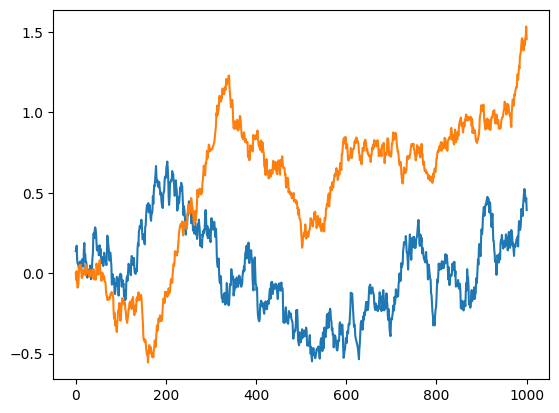

In [6]:
plt.plot(test_Double_Well_sig_data[5])
plt.plot(test_Double_Well_obv_data[5])

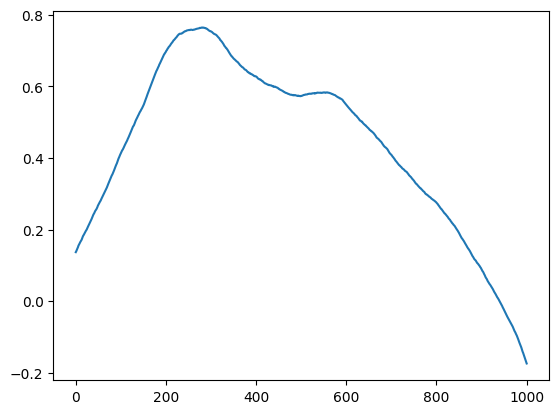

In [22]:
plt.plot(tf.reduce_mean(particle_filters[0], axis=0))

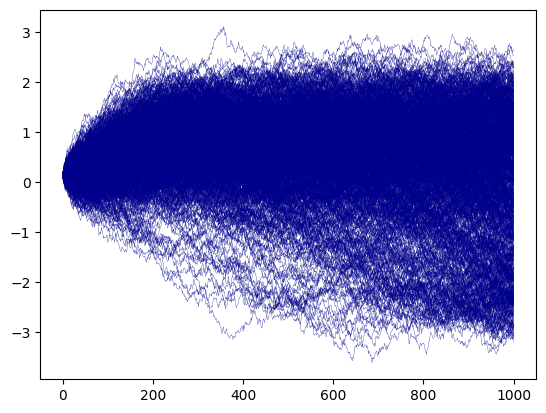

In [23]:
for trajectory in particle_filters[0][:800]:
    plt.plot(trajectory, color='darkblue', linewidth=0.2)